In [1]:
import numpy as np
import glob, os, string, import_ipynb, copy
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import drawingGraph as G
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Using TensorFlow backend.


importing Jupyter notebook from drawingGraph.ipynb


In [2]:
def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index

In [3]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        loc = getIndexFromGraph(graph_group[index])
        num_dict[loc] += 1
    return num_dict

In [4]:
def getEmbeddingSum():
    sum_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        loc = getIndexFromGraph(graph_group[index])
        sum_embedding[loc] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [5]:
def getEmbeddingAvg():
    avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for index in range(graph_length):
        avg_embedding[index] = sum_embedding[index] / num_dict[index]
    return avg_embedding

In [6]:
def getEmbeddingVector(index):
    data_index = []
    data = []
    counts = num_dict[index]
    for num, i in enumerate(graph_group):
        if index == getIndexFromGraph(i):
            data_index.append(num)
        if len(data_index) == counts:
            break
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [7]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [8]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            mode_embedding[index][count] = getMode(values)
        mode_embedding[index] = np.array(mode_embedding[index])
    return mode_embedding

In [9]:
def getEmbeddingExceptMinMax():
    except_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            values.sort()
            except_embedding[index][count] =  values[1:-1].mean()
        except_embedding[index] = np.array(except_embedding[index])
    return except_embedding

In [10]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [228]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    check = [0 for i in range(graph_length)]
    names = []
    for item in ordered:
        for index, d in enumerate(dist):
            if item == d and not check[index]:
                names.append(index)#+1)
                check[index] = 1
                break
    return names, ordered

In [161]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for embed in embeddings:
        if distance_measure == 'euc':
            dist.append(euclidean_distance(obj, embed))
        else:
            dist.append(cosine_distance(obj, embed))
    return dist

In [233]:
def getTopData(n, datasets, names):
    data = []
    for i in names[:n+1]:
        data.append(datasets[i])
    return data

In [239]:
filename = 'last_mse_kld_lstmae' #input('filename: ')
json_file = open("res/kld/" + filename +".json", "r") #"+filename+"
loaded_model_json = json_file.read() 
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('res/kld/weights_'+ filename + '.h5')

In [240]:
graph_length =1260#1080 #1260#len(glob.glob('./latest_graph_data/*')) 
embedded_length = 64

In [241]:
#dir = './latest_sequence/bfs-character/graph'
dir = './datasets/last_seq/bfs-chr/graph'

# file read
graph_group = []
all_data = []
chr_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)

for gl in range(graph_length):
    filename = dir + str(gl) + "-*"
    for file in sorted(glob.glob(filename)):
        datasets = []
        chr_dts = []
        graph_group.append(file.split('/')[-1].replace('.txt', ''))
        with open(file) as f:
            for line in f.readlines():
                (u, v, w) = line[1:-2].split(', ')
                chr_dts.append([u[1], v[1], float(w)])
                datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
        chr_data.append(chr_dts)        
all_data = np.array([np.array(arr) for arr in all_data])

In [242]:
g_dir = "./datasets/last_graph/graph"
all_graph = []
for gl in range(graph_length):
    filename= g_dir + str(gl) + ".txt"
    adj_graph = []
    with open(filename, 'r') as f:
        for index, line in enumerate(f.readlines()):
            if index == 0:
                continue
            adj_graph.append(list(map(float, line[:-1].split(' ')))[1:])
    all_graph.append(adj_graph)

In [243]:
lstm_autoencoder = loaded_model

In [244]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [245]:
num_dict = { i:0 for i in range(graph_length)}
num_dict = calculateGraphGroup(num_dict)

In [246]:
sum_embedding = getEmbeddingSum()
avg_embedding = getEmbeddingAvg()
mode_embedding = getEmbeddingMode()
except_embedding = getEmbeddingExceptMinMax()

In [247]:
def calcuPrecision(arr, ans):
    cnt = 0
    for a in arr:
        if int(a/210) == ans:
            cnt += 1
        #if a  >= ans +125 and a < ans + 150:
        #    cnt -= 1
    return cnt

In [267]:
import random as rd

ch = [0 for i in range(graph_length)]
mode_precision = 0
avg_precision = 0
except_precision = 0
top = 11

for i in range(210, 1261, 210): #for i in range(210, 1261, 210):
    print("*********************", i)
    for idx in range(20):
        n = rd.randint(i-210, i-1) #n = rd.randint(i-210, i-1)
        #n1 = rd.randint(900+(int(i/150)-1)*60, 900+(int(i/150)*60)-1)
        while ch[n] == 1:
            n = rd.randint(i-210, i-1)#n = rd.randint(i-210, i-1)
        #print(n, i-210, i-1)
        ch[n] = 1
        
        avg_obj = avg_embedding[n]
        mode_obj = mode_embedding[n]
        except_obj = except_embedding[n]
        
        dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
        names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)
        dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
        names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)
        dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
        names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)
        
        #print(n, names_avg_cos[1:top], names_mode_cos[1:top], names_except_cos[1:top])
        #print(names_avg_cos[:top])
        avg_precision += calcuPrecision(names_avg_cos[1:top+1], int(n/210))
        mode_precision += calcuPrecision(names_mode_cos[1:top+1], int(n/210))
        except_precision += calcuPrecision(names_except_cos[1:top+1], int(n/210))

********************* 210
********************* 420
********************* 630
********************* 840
********************* 1050
********************* 1260


In [268]:
i=2
if top == 11:
    print( avg_precision/(600*i), mode_precision/(600*i), except_precision/(600*i))
elif top == 21:
    print( avg_precision/(1200*i), mode_precision/(1200*i), except_precision/(1200*i))
elif top == 31:
    print( avg_precision/(1800*i), mode_precision/(1800*i), except_precision/(1800*i))
elif top == 51:
    print( avg_precision/(3000*i), mode_precision/(3000*i), except_precision/(3000*i))

0.855 0.8191666666666667 0.8483333333333334


In [250]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
loc = './datasets/last_seq/bfs/graph'
datasets = [[] for i in range(graph_length)]
for idx in range(graph_length):
    filename = loc + str(idx) + "-1.txt"
    d = []
    with open(filename) as f:
        for line in f.readlines():
            u, v, w = line[1:-2].split(', ')
            d.append([int(u), int(v), float(w)])
    datasets[idx] = d

In [251]:
mode_obj = mode_embedding[650]
sum_obj = sum_embedding[650]
avg_obj = avg_embedding[650]
except_obj = except_embedding[650]

In [252]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [253]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
top10_sum_cos = getTopData(10, datasets, names_sum_cos)
top10_avg_cos = getTopData(10, datasets, names_avg_cos)
top10_except_cos = getTopData(10, datasets, names_except_cos)

In [254]:
# check top n results
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
for idx, s, a, m, e in zip(range(0, len(names_sum_cos)), names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
#for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print(idx, '{:8d}{:8d}{:8d}{:8d}'.format(s, a, m, e))
    count += 1
    if count >= 21:
        break


    sum     avg     mode    except(min, max)
0      650     650     650     650
1      654     654     824     824
2      824     824     825     825
3      825     825     710     654
4      710     710     644     710
5      644     644     654     644
6      808     808     788     649
7      706     706     634     808
8      649     649     707     706
9      656     656     649     656
10      658     658     652     712
11      788     788     808     788
12      712     712     712     816
13      634     634     737     707
14      707     707     739     739
15      632     632     706     638
16      638     638     657     658
17      816     816     658     634
18      739     739     656     737
19      643     643     816     643
20      652     652     651     652


In [256]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        print(obj)
        G.drawGraph(dir_name, 'graph' + str(drawobj_name[index]), index, obj, save)

cos mode
[[1, 2, 12.99], [1, 3, 18.05], [2, 3, 3.55], [2, 4, 2.12], [2, 5, 9.67], [3, 5, 3.98], [3, 6, 5.94], [4, 5, 4.73], [5, 6, 8.91]]


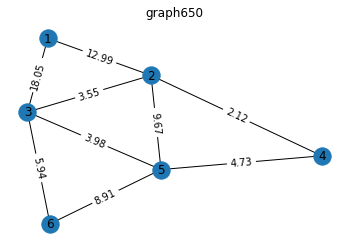

[[1, 2, 13.69], [1, 3, 13.31], [2, 3, 10.04], [2, 4, 16.57], [2, 5, 6.9], [3, 5, 7.57], [3, 6, 15.68], [4, 5, 8.76], [5, 6, 14.21]]


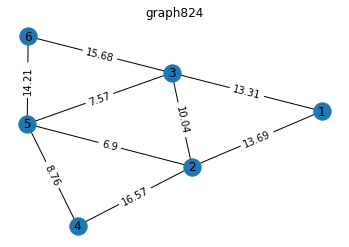

[[1, 2, 13.69], [1, 3, 13.31], [2, 3, 10.04], [2, 4, 16.57], [2, 5, 6.9], [3, 5, 7.57], [3, 6, 15.68], [4, 5, 8.76], [5, 6, 14.21]]


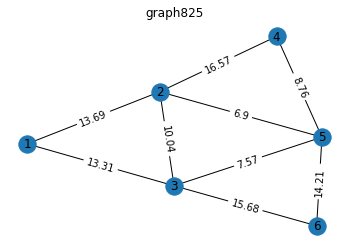

[[1, 2, 9.6], [1, 3, 8.29], [2, 3, 6.03], [2, 4, 3.25], [2, 5, 10.86], [3, 5, 4.03], [3, 6, 6.6], [4, 5, 2.13], [5, 6, 9.97]]


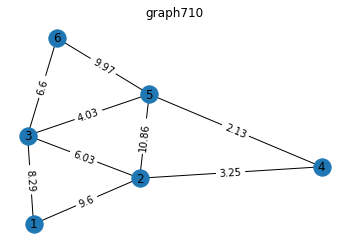

[[1, 2, 9.73], [1, 3, 18.65], [2, 3, 2.56], [2, 4, 19.06], [2, 5, 18.5], [3, 5, 2.7], [3, 6, 7.47], [4, 5, 9.5], [5, 6, 12.06]]


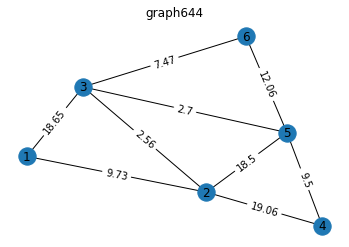

[[1, 2, 19.17], [1, 3, 12.14], [2, 3, 4.55], [2, 4, 0.14], [2, 5, 9.33], [3, 5, 9.42], [3, 6, 16.22], [4, 5, 7.14], [5, 6, 6.27]]


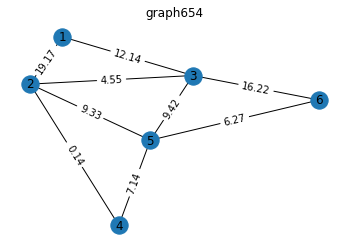

[[1, 2, 19.68], [1, 3, 12.35], [2, 3, 14.26], [2, 4, 15.89], [2, 5, 9.79], [3, 5, 12.21], [3, 6, 4.9], [4, 5, 5.11], [5, 6, 0.82]]


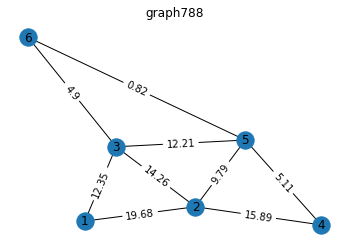

[[1, 2, 12.07], [1, 3, 10.44], [2, 3, 4.5], [2, 4, 5.47], [2, 5, 12.22], [3, 5, 9.51], [3, 6, 11.66], [4, 5, 2.09], [5, 6, 13.32]]


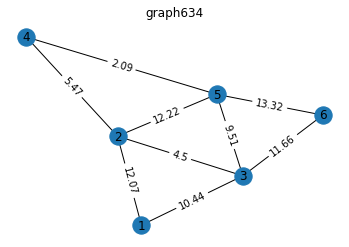

[[1, 2, 13.18], [1, 3, 12.03], [2, 3, 11.68], [2, 4, 7.78], [2, 5, 11.05], [3, 5, 7.28], [3, 6, 4.54], [4, 5, 13.64], [5, 6, 5.86]]


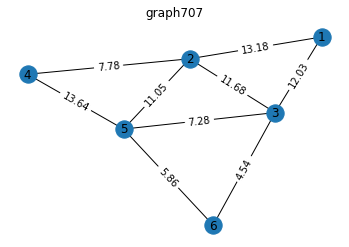

[[1, 2, 4.94], [1, 3, 7.72], [2, 3, 1.36], [2, 4, 16.09], [2, 5, 15.77], [3, 5, 3.47], [3, 6, 5.06], [4, 5, 12.88], [5, 6, 4.44]]


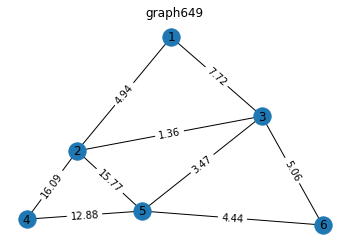

[[1, 2, 4.12], [1, 3, 4.86], [2, 3, 14.19], [2, 4, 0.63], [2, 5, 14.2], [3, 5, 5.17], [3, 6, 12.49], [4, 5, 15.55], [5, 6, 7.69]]


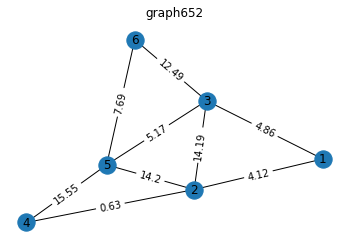

In [258]:
print("cos mode")
draw(top10_mode_cos, names_mode_cos, '', False)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1260 samples in 0.001s...
[t-SNE] Computed neighbors for 1260 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1260
[t-SNE] Computed conditional probabilities for sample 1260 / 1260
[t-SNE] Mean sigma: 0.151428
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.802010
[t-SNE] KL divergence after 1000 iterations: 0.761517


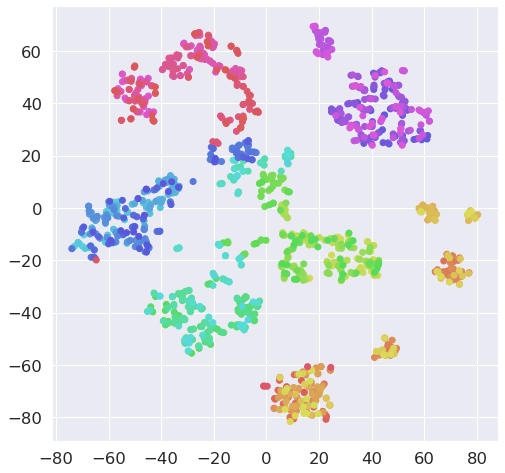

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
labels = [str(i) for i in range(len(except_embedding))]
tsne_train_xs = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000).fit_transform(except_embedding, labels)
plt.figure(figsize=(8, 8))
plt.scatter(x = tsne_train_xs[:,0], y=tsne_train_xs[:,1], color=sns.color_palette("hls", len(except_embedding)))

#for i in [0, 501, 525, 526]:
#    plt.annotate(str(i), (tsne_train_xs[i, 0], tsne_train_xs[i, 1]))


plt.show()